In [41]:
import numpy as np
import pinocchio
import crocoddyl

# from crocoddyl.utils.biped import plotSolution

# Load a robot model from URDF
urdf_model_path = "/home/tema05/workspace/SBER/files/3r.urdf"
robot = pinocchio.robot_wrapper.RobotWrapper.BuildFromURDF(urdf_model_path)
robot_model = robot.model

## Set parameters
# initial position [x, y]  |x|<=3.0, |y|<=3.0
q0 = np.array([np.deg2rad(30), np.deg2rad(30), np.deg2rad(120)]).T

# target point [x, y]  |x|<=3.0, |y|<=3.0
Z = [2.1, 1.8]
target = np.array([Z[0], 0, Z[1]])

DT = 1e-3  # time step
T = 1000  # number of knots

# torque limits [joint1, joint2, joint3]
robot_model.effortLimit = np.array([10, 10, 10])

# Create data structures
robot_data = robot_model.createData()
state = crocoddyl.StateMultibody(robot.model)
display = crocoddyl.MeshcatDisplay(robot, floor=True, visibility=False)

# Create the cost functions
goalResidual = crocoddyl.ResidualModelFrameTranslation(
    state, robot_model.getFrameId("end_effector"), target
)
goalTrackingCost = crocoddyl.CostModelResidual(state, goalResidual)
xRegCost = crocoddyl.CostModelResidual(state, crocoddyl.ResidualModelState(state))
uRegCost = crocoddyl.CostModelResidual(state, crocoddyl.ResidualModelControl(state))

# Create cost model per each action model
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)

# Then let's added the running and terminal cost functions
runningCostModel.addCost("gripperPose", goalTrackingCost, 1.0)
# runningCostModel.addCost("stateReg", xRegCost, 5e-2)
runningCostModel.addCost("ctrlReg", uRegCost, 1e-5)
terminalCostModel.addCost("gripperPose", goalTrackingCost, 1000.0)
# terminalCostModel.addCost("stateReg", xRegCost, 5e-2)
terminalCostModel.addCost("ctrlReg", uRegCost, 1e-5)

# Create the action model
actuation = crocoddyl.ActuationModelFull(state)
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuation, runningCostModel
    ),
    DT,
)
# runningModel.u_lb = np.array([l_lim, l_lim, l_lim, l_lim])
# runningModel.u_ub = np.array([u_lim, u_lim, u_lim, u_lim])

terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuation, terminalCostModel
    )
)
# runningModel.differential.armature = 0.2 * np.matrix(np.ones(state.nv)).T
# terminalModel.differential.armature = 0.2 * np.matrix(np.ones(state.nv)).T

# Create the problem
x0 = np.concatenate([q0, pinocchio.utils.zero(state.nv)])
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

# Creating the DDP solver for this OC problem, defining a logger
solver = crocoddyl.SolverDDP(problem)
solver.setCallbacks(
    [
        crocoddyl.CallbackVerbose(),
        crocoddyl.CallbackLogger(),
    ]
)

# Solving it with the DDP algorithm
solver.solve()

# Visualizing the solution
display.displayFromSolver(solver)

xT = solver.xs[-1]
pinocchio.forwardKinematics(robot_model, robot_data, xT[: state.nq])
pinocchio.updateFramePlacements(robot_model, robot_data)
print(
    "Finally reached = ",
    robot_data.oMf[robot_model.getFrameId("end_effector")].translation.T,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7013/static/
iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  6.909e+03  0.000e+00  1.619e+03  3.237e+03  1.000e-09  1.000e-09  1.0000  2.094e+00  0.000e+00  0.000e+00  1.619e+03 -4.887e+03  0.000e+00  0.000e+00
   1  1.302e+03  0.000e+00  6.909e+03  1.382e+04  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  5.181e+03  5.608e+03  0.000e+00  0.000e+00
   2  1.006e+03  0.000e+00  1.300e+03  2.600e+03  1.000e-09  1.000e-09  0.1250  0.000e+00  0.000e+00  0.000e+00  3.047e+02  2.960e+02  0.000e+00  0.000e+00
   3  1.636e+02  0.000e+00  1.004e+03  2.008e+03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.004e+03  8.421e+02  0.000e+00  0.000e+00
   4  5.971e+01  0.000e+00  1.577e+02  3.153e+02  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.577e+02  1.039e+02 

AttributeError: 'CostModelResidual' object has no attribute 'get_reference'

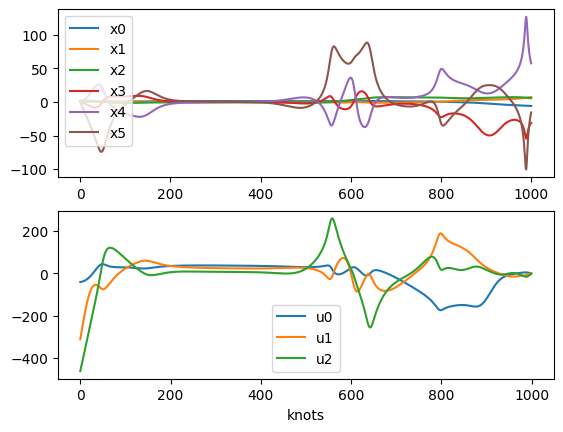

In [42]:
log = solver.getCallbacks()[1]
crocoddyl.plotOCSolution(
    log.xs,
    log.us,
    figIndex=1,
    show=False,
)
# crocoddyl.plotConvergence(
#     log.costs, log.pregs, log.dregs, log.grads, log.stops, log.steps, figIndex=2
# )

## I. DifferentialActionModel for Pinocchio ABA
This scenario uses an action model that computes 2nd order differential dynamics with Pinocchio. Note that it can accept several cost models. This action model is tailored for robot applications, and at the same time, it's modular since:
 - you can modify the robot dynamics by changing Pinocchio model, and
 - you can formulate any cost function by simply adding running a terminal costs.

## II. Cost models

A cost model computes a scalar cost value and its gradient and Hessian. All the models implemented are computing a cost residual and are computing the Hessian with the Gauss approximation.

We implemented reusable cost models for controlling 
 - a frame placement (translation or velocity),
 - the center of mass position, and 
 - state  and control spaces.

In the example above, we used the CostModelFrameTranslation which defines a 3d position task, and the state and control regularizers.

As for any cost model in crocoddyl, if you write your own cost model you need to create a data class for your cost function. The cost data must be created from a pinocchio data (the rational is that the pinocchio data used to compute the dynamics should be re-used to compute the cost).


In [ ]:
dataCollector = crocoddyl.DataCollectorMultibody(robot.data)
trackData = goalTrackingCost.createData(dataCollector)

### II.a Frame position cost

You define a frame ID and the reference position as a 3D array. The cost is the distance between the frame and the target. This cost depends on $\mathbf{x}$ (specifically the configuration $\mathbf{q}$). You can double check the 0s in its gradient.

In [ ]:
pinocchio.updateFramePlacements(robot.model, robot.data)
pinocchio.computeJointJacobians(robot.model, robot.data, xT[: state.nq])
goalTrackingCost.calc(trackData, x0)
goalTrackingCost.calcDiff(trackData, x0)
print(trackData.Lx, trackData.Lu)

### II.b State cost
In this part of the tutorial you must define a State model. It defines 
 - the dimension of the state and its tangent, and
 - the exponential/integrate and difference/log operators.
The operators can described using Pinocchio functions. And the exercite consists on adding them into your State class. Please note crocoddyl has abstract functions for this.

The state cost uses a reference in state space (State.zero() by default). The cost is the distance, computed with state.difference between the current state and the reference. Hence, with this cost, we regularize both position and velocity.

### II.c Control cost

The control cost uses a control reference as in the state cost. The cost is the distance the current control and the reference. Hence the cost regularizes torque commands.

### II.d Add cost models to the differential action model
Each time we want to include a new cost function, we use addCost function inside our DAM. In this function you're also able its weight.

## III. Create the problem with integrated action model
Differential action models describe cost and dynamics in continuous-time, however our optimal control solvers work in discrete-time. We have created the integrated action model in order to deal with this.

In the previous code, we have used an abstract class that uses simpletic Euler rules. In the cartpole exercise you have learnt how to use integrated action models for your problem.

## IV. Callbacks

Callback functions are needed for analysing and debugging the performance of the solver for your specific problem.
For problems defined with Pinocchio, you can display the robot trajectory per each iterate by including CallbackDisplay. With this callback, you can display robot motions with different rates. Additionally, CallbackVerbose prints a message that allows us to understand the behaviour of the solver.

Generally speaking, an user is able to describe any callback function. This function will be run once per iterate and it has access to all data.

## VI. Modifying the example

Start by defining several targets (let's say 4 targets, all at x=0.4, and at y and z being either 0 or 0.4), and display then in the viewer.


The shooting problem will be composed of 4 sequences of action models. Each sequence consists on T shooting "running" nodes and 1 terminal node. The running nodes mostly have regularization terms, while the terminal nodes have a strong cost toward the respective target.

[ R1,R1,R1 ... R1,T1, R2,R2 .... R2, T2, R3 ... R3, T3, R4 ... R4 ] , T4

First create 4 running models and 4 terminal models.

Then you need to add a position cost, and state and control regularization to each running action model. Please  note that for terminal action model is only needed the position cost. Additionally, in the running models, the position cost should be low, and it should be high in the terminal models.

Now create a shooting problem.

In [ ]:
seq0 = [runningModels[0]] * T + [terminalModels[0]]
seq1 = [runningModels[1]] * T + [terminalModels[1]]
seq2 = [runningModels[2]] * T + [terminalModels[2]]
seq3 = [runningModels[3]] * T
problem = crocoddyl.ShootingProblem(x0, seq0 + seq1 + seq2 + seq3, terminalmodel[3])

Create a DDP solver for this problem and run it. 

In [ ]:
ddp = crocoddyl.SolverDDP(problem)
ddp.solve()

Well, it should not work, at least no on the first shot. The DDP solver is likely not strong enough to accept the random weights that you have selected. 

If it is working nicely from the first shot, display it in the viewer and go take a coffee. But you will likely have to tweak the gains to make it work.

**It is suggested to first optimize only sequence 1. When you are happy with it, add sequence 2 and optimize again, etc.**


## V. Penalty
The solver works with double precisions, so it is quite robust to high weight. 10000 is likely to be accepted for example. But if you make the problem too difficult, the solver will break. 

In that case, you can implement a simple penalty solver by setting the weight to be 10**i, and creating a for loop to explore i from 0 to 5. At each iteration of the loop, run the solver from the previous solution and for few iterations only.

In [ ]:
for i in range(1, 6):
    for m in terminalModels:
        m.costs.costs["gripperPose"].weight = 10**i
    ddp.solve(ddp.xs, ddp.us, 10)